# Time Series Analysis

This notebook estimates autocorrelations, and discusses the properties of AR, MA and VAR models.

## Load Packages

In [1]:
using Dates, DelimitedFiles, LinearAlgebra, Distributions, StatsBase

include("jlFiles/printmat.jl")    
include("jlFiles/printTable.jl")
include("jlFiles/ARMAFilter.jl")
include("jlFiles/VARFilter.jl")
include("jlFiles/lagnFn.jl")

printblue(txt) = printstyled(string(txt,"\n"),color=:blue,bold=true)

printblue (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))             #pyplot() or gr()
gr(size=(480,320))
default(fmt = :svg)

## Load Data

In [3]:
xx  = readdlm("Data/RvSP500.csv",',',skipstart=1)
y   = xx[:,3]            #SP500 log realized monthly volatility
xx  = nothing

T   = size(y,1)
println("Sample size: $T")

Sample size: 574


# Descriptive Statistics

## Autocorrelations

That is, the correlation of $y_{t}$ and $y_{t-s}$ for different values of $s$. It is a useful tool for describing the properties of your data.

It can be shown that the t-stat of an autocorrelation is $\sqrt{T}$ times the autocorrelation. 

We can test the first $L$ autocorrelations by the Box-Pierce test.

In [4]:
L = 5                
lags = 1:L
ρ = autocor(y,lags)         #using the StatsBase package

printblue("Autocorrelations")
println("       lag   autocorrr  t-stat")
printmat(Any[lags ρ sqrt(T)*ρ])     #Any[] to print lags as integers

BP = T*sum(ρ.^2)

printblue("Box-Pierce test stat and 10% critical value")
printmat([BP quantile(Chisq(L),0.9)])

Autocorrelations
       lag   autocorrr  t-stat
         1     0.709    16.982
         2     0.602    14.419
         3     0.529    12.684
         4     0.459    11.000
         5     0.455    10.903

Box-Pierce test stat and 10% critical value
   897.040     9.236



# White Noise

To estimate: traditional sample mean and standard deviation.

In [5]:
μ = mean(y)
σ = std(y)

printlnPs("Mean and std:",μ,σ)

Mean and std:     2.567     0.437


# AR(p)

This section discusses the properties and estimation of autoregressive (AR) processes.

## Impulse Response Function of AR Processes

The next cell shows how a shock to an AR process propagates over time (the "impulse response function"). This is a useful tool for understanding the properties of the model. 

The two models use in the calculates are an AR(1)

$
y_t = a y_{t-1} + \epsilon_t
$

and an AR(2)

$
y_t = a_1 y_{t-1} + a_2 y_{t-2} + \epsilon_t.
$

For *stationary models*, the impulse response function eventually converges to zero. That is, the effect of a shock eventually disappears.

The impulse responses to y1 (AR(1)) and y2 (AR(2)):
    period        y1        y2
         0     1.000     1.000
         1     0.850     0.850
         2     0.722     0.222
         3     0.614    -0.236
         4     0.522    -0.312
         5     0.444    -0.147
         6     0.377     0.031
         7     0.321     0.100
         8     0.272     0.069



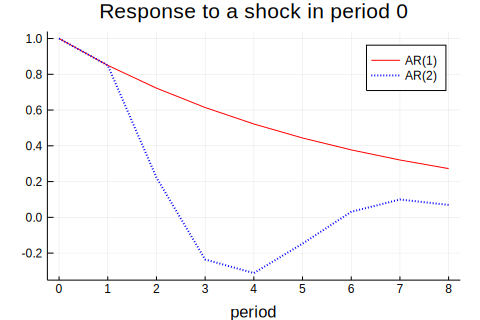

In [6]:
a = 0.85              #AR(1)

(a₁,a₂) = (0.85,-0.5)  #AR(2)

ϵ = [0;0;1;zeros(8)]  #a shock in period 3, otherwise zeros              
T = length(ϵ)
periods = 0:T-3

(y1,y2) = (zeros(T),zeros(T))           #convenient to start with zeros
for t = 3:T
    y1[t] = a*y1[t-1] + ϵ[t]
    y2[t] = a₁*y2[t-1] + a₂*y2[t-2] + ϵ[t]  #or y2 = ARMAFilter(ϵ,[a₁,a₂])
end    
y1 = y1[3:end]                           #cutting padded part
y2 = y2[3:end]

printblue("The impulse responses to y1 (AR(1)) and y2 (AR(2)):")
printTable(Any[periods y1 y2],["period","y1","y2"],fill("",T))


plot( periods,y1,label="AR(1)",color=:red,xticks=-2:T-2)
plot!(periods,y2,label="AR(2)",color=:blue,line=(:dot,2))
xlabel!("period")
title!("Response to a shock in period 0")

## (extra) The Roots of an AR Model

The *roots* of an AR(p) is a formal way of determining whether it is stationary. 

An easy way to calculate the roots is to first transform the AR(p) to a V(ector)AR(1) and then calculate the eigenvalues. If their absolute values are lower than one, then the model is stationary.

For instance, an AR(2)

$
y_t = a_1 y_{t-1} + a_2 y_{t-2} + \epsilon_t.
$

can be written as a 2-variable VAR(1) 

$
z_t = A_1 z_{t-1} + u_t,
$

where 

$z_t = 
\begin{bmatrix} 
y_t \\ 
y_{t-1}  
\end{bmatrix}$

and

$A_1 = 
\begin{bmatrix} 
a_1 & a_2\\ 
1 & 0 
\end{bmatrix}.$

In [7]:
"""
    Companion form of AR(p), that is, write AR(p) as a VAR(1)
"""
function CompanionFormAR(a)
    p = length(a)
    if p > 1                      #if order > 1
        A1 = vcat(a',[I  zeros(p-1)])
    else                          #if already VAR(1)
        A1 = copy(a)
    end
    return A1
end

CompanionFormAR

In [8]:
λ = eigen(CompanionFormAR([a₁,a₂])).values    #eigenvalues of the companion form 

println("absolute values of the eigenvalues: should be < 1 for stationarity")
printmat(abs.(λ))

absolute values of the eigenvalues: should be < 1 for stationarity
     0.707
     0.707



## Estimation of an AR Process

AR models can be estimated by OLS.

The next cell defines a function estimating an AR(p) process. It calls on `lagnFn(y,s)` which is a convenience function for constructing a $Txn$ matrix with lag $s$ of $y$, padded with `NaN` at the top. 

In [9]:
function ARpEst(y,p)
    T    = length(y)
    y_p  = y[p+1:end]       #dependent variable
    xAll = fill(NaN,(T,p))  #build matrix of regressors
    for s = 1:p
        xAll[:,s] = lagnFn(y,s)
    end    
    xAll = [xAll[p+1:end,:] ones(T-p)]   #add constant last
    #printmat([y_p xAll][1:10,:])        #uncomment to see the regressors
    b  =  xAll\y_p          #OLS 
    a = b[1:end-1]        #slopes
    return a
end

ARpEst (generic function with 1 method)

In [10]:
aAR1 = ARpEst(y,1)
aAR2 = ARpEst(y,2)

printlnPs("Estimated AR(1) coef: ",aAR1)
printlnPs("Estimated AR(2) coefs: ",aAR2)

Estimated AR(1) coef:      0.713
Estimated AR(2) coefs:      0.569     0.204


# Forecasting with an AR Process

Forecasts can be calculated recursively. For instance, for an AR(2) and data on $(y_{-1},y_0$), we can calculate the forecast for $t=1$ as 

$
\textrm{E}_0 y_1 = a_1 y_0 + a_2 y_{-1}.
$

Then, the forecast for $t=2$ (still based on the information in $t=0$) is 

$
\textrm{E}_0 y_2 = a_1 \textrm{E}_0 y_1 + a_2 y_0.
$

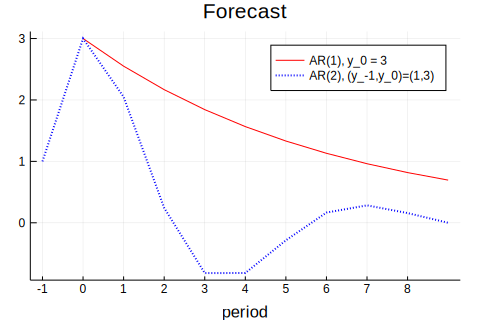

In [11]:
T = 10

y1 = [3;zeros(T-1)]
for t = 2:T                       #AR(1)
    y1[t] = a*y1[t-1]
end
periods1 = 0:T-1

y2 = [1;3;zeros(T-1)]             #y[-1] = 1, y[0] = 3, notice the order
for t = 3:T                       #AR(2)
    y2[t] = a₁*y2[t-1] + a₂*y2[t-2]
end
periods2 = -1:T-1

plot(periods1, y1,label="AR(1), y_0 = 3",color=:red,xticks=-2:T-2)
plot!(periods2,y2,label="AR(2), (y_-1,y_0)=(1,3)",color=:blue,line=(:dot,2))
xlabel!("period")
title!("Forecast")

In [12]:
printblue("We can also use the ARMAFilter() function to do the forecasts")

y2b = ARMAFilter(zeros(T-1),[a₁,a₂],[],1,[1,3])
y2b = [[1,3];y2b]       #pad the initial values to get same as in figure

printTable(Any[-1:T-1 y2b],["period","forecast"],fill("",1+T))

We can also use the ARMAFilter() function to do the forecasts
    period  forecast
        -1     1.000
         0     3.000
         1     2.050
         2     0.242
         3    -0.819
         4    -0.817
         5    -0.285
         6     0.166
         7     0.284
         8     0.158
         9    -0.007



## Partial Autocorrelations

The partial autocorrelation coefficient is the regression coefficients on $x_{t-p}$ in an AR(p) regression. It is a useful tool for describing the properties of your data.

In [13]:
pac = pacf(y,lags)

printblue("autocorrelations and  partial autocorrelations")
println("       lag    autocorr     pac")
printmat(Any[lags ρ pac])

autocorrelations and  partial autocorrelations
       lag    autocorr     pac
         1     0.709     0.713
         2     0.602     0.204
         3     0.529     0.103
         4     0.459     0.031
         5     0.455     0.130



# MA(q)

This section discusses the properties and estimation of moving average (MA) processes.

## Impulse Response Function of an MA Process

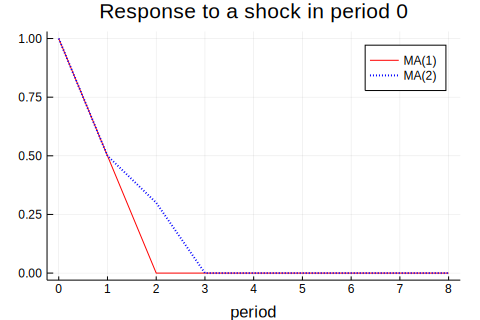

In [14]:
θ = 0.5             #MA(1)

(θ₁,θ₂) = (0.5,0.3)  #MA(2)

ϵ = [0;0;1;zeros(8)]  #a shock in period 3, otherwise zeros              
T = length(ϵ)
periods = 0:T-3

(y1,y2) = (fill(NaN,T),fill(NaN,T))       
for t = 3:T                                
    y1[t] = ϵ[t] + θ*ϵ[t-1]
    y2[t] = ϵ[t] + θ₁*ϵ[t-1] + θ₂*ϵ[t-2]   #or y2=ARMAFilter(ϵ,[],[θ₁,θ₂])
end        
y1 = y1[3:end]                           #cutting padded part
y2 = y2[3:end]


plot( periods,y1,label="MA(1)",color=:red,xticks=periods)
plot!(periods,y2,label="MA(2)",color=:blue,line=(:dot,2))
xlabel!("period")
title!("Response to a shock in period 0")

## (extra) Estimation of an MA(q)

In [15]:
function MAqLL(par::Vector,y)
    (θ,σ) = (par[1:end-1],par[end])   
    q     = length(θ)
    ϵ     = ARMAFilter(y,-θ)           #ϵ is AR(q) with coefs -θ
    LL_i  = -1/2*log(2*pi) .- 1/2*log(σ^2) .- 1/2*ϵ.^2/σ^2
    LL    = sum(LL_i)                  #sum(log-likelihood values)
    return LL,ϵ
end

MAqLL (generic function with 1 method)

In [16]:
using Optim                             

par0 = [0.5,0.3,0,0,1]   #θ₁,θ₂,θ₃,θ₄,σ         #estimate an MA(4)
Sol = optimize(par->-MAqLL(par,y)[1],par0)    #minimize -LL

θ = Optim.minimizer(Sol)[1:end-1]
σ = Optim.minimizer(Sol)[end]

printblue("MLE of MA(4):")
printTable([θ;σ],["parameters"],["θ₁","θ₂","θ₃","θ₄","σ"])

MLE of MA(4):
  parameters
θ₁     1.458
θ₂     1.552
θ₃     1.170
θ₄     0.516
σ      0.638



In [17]:
λ = eigen(CompanionFormAR(-θ)).values    #eigenvalues of the companion form 

println("absolute values of the eigenvalues: should be < 1 for MLE to be valid")
printmat(abs.(λ))

absolute values of the eigenvalues: should be < 1 for MLE to be valid
     0.901
     0.901
     0.798
     0.798



# VAR(p)

This section discusses the properies and estimation of vector autoregressive (VAR) processes.

## Impulse Response Function of a VAR(1) Process

The cells below shows the impulse response function for a 2-variable VAR(1)

$
y_t = A_1 y_{t-1} + \epsilon_t
$,

where 

$A_1 = 
\begin{bmatrix} 
0.5 & 0.2\\ 
0.1 & -0.3 
\end{bmatrix}.$

The code calls on the function `VARFilter` (which was included at the top of the notebook.)

In [18]:
A1 = [0.5 0.2;
      0.1 -0.3]

ϵ1    = [0 0;0 0;1 0;zeros(T-3,2)]            #shock to variable 1 in t=0
IR_ϵ1 = VARFilter(ϵ1,A1,zeros(1,2))           #IR of both variables 
ϵ2    = [0 0;0 0;0 1;zeros(T-3,2)]            #shock to variable 2 in t=0
IR_ϵ2 = VARFilter(ϵ2,A1,zeros(1,2))           #IR of both variables 
IR_ϵ1 = IR_ϵ1[3:end,:]                        #cutting padded part
IR_ϵ2 = IR_ϵ2[3:end,:]

periods = 0:T-3

printblue("The impulse responses:")
printTable(Any[periods IR_ϵ1 IR_ϵ2],["period","ϵ1->y1","ϵ1->y2","ϵ2->y1","ϵ2->y2"],fill("",T-2))

The impulse responses:
    period    ϵ1->y1    ϵ1->y2    ϵ2->y1    ϵ2->y2
         0     1.000     0.000     0.000     1.000
         1     0.500     0.100     0.200    -0.300
         2     0.270     0.020     0.040     0.110
         3     0.139     0.021     0.042    -0.029
         4     0.074     0.008     0.015     0.013
         5     0.038     0.005     0.010    -0.002
         6     0.020     0.002     0.005     0.002
         7     0.011     0.001     0.003    -0.000
         8     0.006     0.001     0.001     0.000



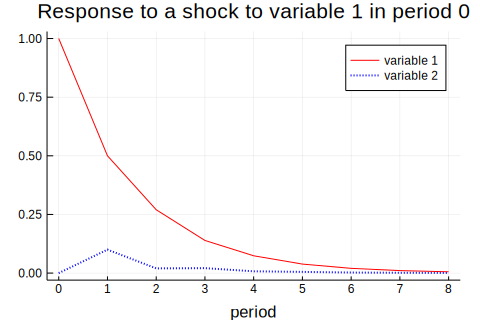

In [19]:
plot( periods,IR_ϵ1[:,1],label="variable 1",color=:red,xticks=-2:T-2)
plot!(periods,IR_ϵ1[:,2],label="variable 2",color=:blue,line=(:dot,2))
xlabel!("period")
title!("Response to a shock to variable 1 in period 0")

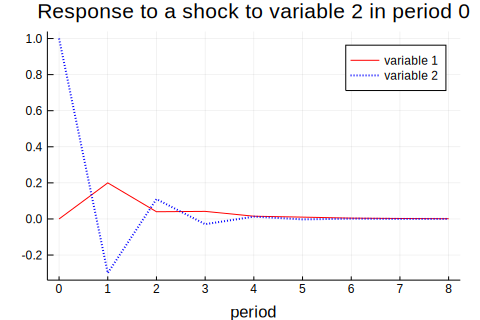

In [20]:
plot( periods,IR_ϵ2[:,1],label="variable 1",color=:red,xticks=-2:T-2)
plot!(periods,IR_ϵ2[:,2],label="variable 2",color=:blue,line=(:dot,2))
xlabel!("period")
title!("Response to a shock to variable 2 in period 0")

## Forecasting with a VAR Process

The cell below shows that forecasting with a VAR is very similar to forecasting with an AR: a simple recursive approach works well.

could also use VARFilter() to do the forecasts
    period        y1        y2
         0     1.000     2.000
         1     0.900    -0.500
         2     0.350     0.240
         3     0.223    -0.037
         4     0.104     0.033
         5     0.059     0.000
         6     0.029     0.006
         7     0.016     0.001
         8     0.008     0.001
         9     0.004     0.000



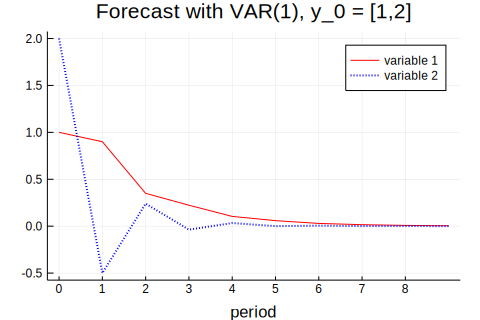

In [21]:
T = 10

y0 = [1 2]                        #initial values in t=0 

y2 = [y0;zeros(T-1,2)]
for t = 2:T
    y2[t,:] = A1*y2[t-1,:]
end    
periods = 0:T-1

printblue("could also use VARFilter() to do the forecasts")
y2b = VARFilter(zeros(T-1,2),A1,y0)
y2b = [y0;y2b]
printTable(Any[periods y2b],["period","y1","y2"],fill("",T))

plot(periods, y2[:,1],label="variable 1",color=:red,xticks=-2:T-2)
plot!(periods,y2[:,2],label="variable 2",color=:blue,line=(:dot,2))
xlabel!("period")
title!("Forecast with VAR(1), y_0 = [1,2]")

# Non-Stationary Processes

The cells below shows the impulse response function and the roots of a non-stationary AR(3).

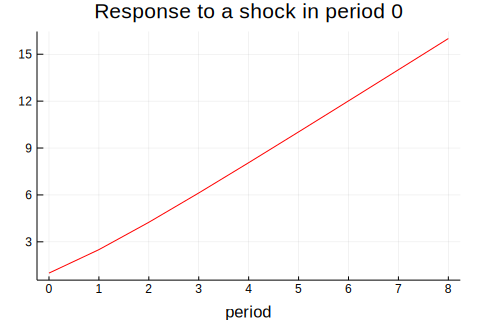

In [22]:
a = [2.5,-2,0.5]                      #AR(3) coefficients

ϵ = [0;0;1;zeros(8)]  #a shock in period 3, otherwise zeros   
T = length(ϵ)
periods = 0:T-3

y1 = ARMAFilter(ϵ,a)
y1 = y1[3:end]

plot( periods,y1,label="",color=:red,xticks=-2:T-2)
xlabel!("period")
title!("Response to a shock in period 0")

In [23]:
λ = eigen(CompanionFormAR(a)).values    #eigenvalues of the companion form 

println("absolute values of the eigenvalues: should be < 1 for stationarity")
printmat(abs.(λ))

absolute values of the eigenvalues: should be < 1 for stationarity
     1.000
     1.000
     0.500

